# Exercise 11.1
## Signal Classification using Dynamic Graph Convolutional Neural Networks
After a long journey through the universe before reaching the earth, the cosmic particles interact with the galactic magnetic field $B$.
As these particles carry a charge $q$ they are deflected in the field by the Lorentz force $F = q \cdot v × B$.
Sources of cosmic particles are located all over the sky, thus arrival distributions of the cosmic particles are isotropic in general. However, particles originating from the same source generate on top of the isotropic
arrival directions, street-like patterns from galactic magnetic field deflections.

In this tasks we want to classify whether a simulated set of $500$ arriving cosmic particles contains street-like patterns (signal), or originates from an isotropic background.

Training graph networks can be computationally demanding, thus, we recommend to use a GPU for this task.

In [63]:
from tensorflow import keras
import numpy as np
from matplotlib import pyplot as plt

layers = keras.layers

print("keras", keras.__version__)

keras 2.9.0


#### Download EdgeConv Layer
A custom implementation of an edge convolution layer. 

In [64]:
import gdown
import os

!wget https://raw.githubusercontent.com/DeepLearningForPhysicsResearchBook/deep-learning-physics/main/edgeconv.py

from edgeconv import EdgeConv

--2022-12-02 22:26:30--  https://raw.githubusercontent.com/DeepLearningForPhysicsResearchBook/deep-learning-physics/main/edgeconv.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6358 (6.2K) [text/plain]
Saving to: ‘edgeconv.py.4’

edgeconv.py.4       100%[===================>]   6.21K  --.-KB/s    in 0s      

2022-12-02 22:26:30 (81.1 MB/s) - ‘edgeconv.py.4’ saved [6358/6358]



### Download Data

In [65]:
url = "https://drive.google.com/u/0/uc?export=download&confirm=HgGH&id=1XKN-Ik7BDyMWdQ230zWS2bNxXL3_9jZq"
output = 'cr_sphere.npz'

if os.path.exists(output) == False:
    gdown.download(url, output, quiet=True)

In [66]:
f = np.load(output)
n_train = 10000
x_train, x_test = f['data'][:-n_train], f['data'][-n_train:]
labels = keras.utils.to_categorical(f['label'], num_classes=2)
y_train, y_test = labels[:-n_train], labels[-n_train:]

In [67]:
print("x_train.shape", x_train.shape)
print("y_train.shape", y_train.shape)
print("f_data", f['data'].shape)

x_train.shape (40000, 500, 4)
y_train.shape (40000, 2)
f_data (50000, 500, 4)


In [88]:
# The data consists of the direction of the cosmic ray (a 3-dim vector) and its measured energy. 
# The following lines separate the spatial coordinate from the "feature" = energy

# define coordinates for very first EdgeConv
train_points, test_points = x_train[..., :3], x_test[..., :3]

# Use normalized Energy as features for convolutional layers
train_features, test_features = x_train[..., -1, np.newaxis], x_test[..., -1, np.newaxis]
train_features = np.concatenate([train_features, train_points], axis=-1)
test_features = np.concatenate([test_features, test_points], axis=-1)

train_input_data = [train_points, train_features]
test_input_data = [test_points, test_features]

In [89]:
print("train_points.shape", train_points.shape)
print("train_features.shape", train_features.shape)

print("test_points.shape", test_points.shape)
print("test_features.shape", test_features.shape)

print("x_test.shape", x_test.shape)
print("x_train.shape", x_train.shape)

train_points.shape (40000, 500, 3)
train_features.shape (40000, 500, 4)
test_points.shape (10000, 500, 3)
test_features.shape (10000, 500, 4)
x_test.shape (10000, 500, 4)
x_train.shape (40000, 500, 4)


### Plot an example sky map

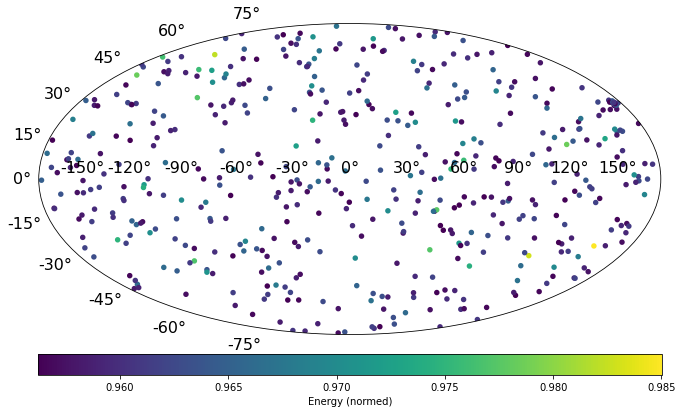

In [70]:
def scatter(v, c=None, zlabel="", title="", **kwargs):

    def vec2ang(v):
        x, y, z = np.asarray(v)
        phi = np.arctan2(y, x)
        theta = np.arctan2(z, (x * x + y * y) ** .5)
        return phi, theta

    lons, lats = vec2ang(v)
    lons = -lons
    fig = plt.figure(figsize=kwargs.pop('figsize', [12, 6]))
    ax = fig.add_axes([0.1, 0.1, 0.85, 0.9], projection="hammer")
    events = ax.scatter(lons, lats, c=c, s=12, lw=2)

    cbar = plt.colorbar(events, orientation='horizontal', shrink=0.85, pad=0.05, aspect=30, label=zlabel)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    return fig


test_id = 0
example_map = x_test[test_id]
fig = scatter(example_map[:, 0:3].T, c=example_map[:, 3], zlabel="Energy (normed)", title = "Event %i" % test_id)

### Design DGCNN

#### Start with defining a kernel network
Design a kernel network. The input to the kernel network is the central pixel coordinate and the neighborhood pixel coordinates.
Hint: using `layers.BatchNormalization` can help to stabilize the training process of a DGCNN.

You can make use of the code snippet below.

Note that the output of the DNN should be `(None, nodes)`, where `None` is a placeholder for the batch size.

In [71]:
def kernel_nn(data, nodes=16):
    d1, d2 = data  # get xi ("central" pixel) and xj ("neighborhood" pixels)
    dif = layers.Subtract()([d1, d2]) # we do as seen in the lecture: x_i - x_i_j, that will lead to more input node in our neural network
    x = layers.Concatenate(axis=-1)([d1, dif])
    x = layers.Dense(nodes, use_bias=False, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(nodes, use_bias=False, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    return x

#### Build complete graph network model
In the first layer, it might be advantageous to choose the next neighbors using the coordinates of the cosmic ray but perform the convolution using their energies also.
Thus, we input `y = EdgeConv(...)[points_input, feats_input]` into the first EdgeConv layer. I.e., the first input is used to build the graph through kNN, the second input are the values of each node that are used in the convolution. 
If we later want to perform a dynamic EdgeConv (we want to update the graph), we simply input `z = EdgeConv(...)(x)`.

To specify the size of the "convolutional filter", make use of the `next_neighbors` argument (searches for $k$ next neighbors for each cosmic ray). 

In [72]:
points_input = layers.Input((500, 3))
feats_input = layers.Input((500, 4))
neighbors=5

x = EdgeConv(lambda a: kernel_nn(a, nodes=8), next_neighbors=neighbors)([points_input, feats_input])  # conv with fixed graph
x = layers.Activation("relu")(x)
x = EdgeConv(lambda a: kernel_nn(a, nodes=8), next_neighbors=neighbors)([points_input, x]) # here we keep the same graph, that is a static graph by using again "points_input"
x = layers.Activation("relu")(x)
x = layers.GlobalAveragePooling1D(name="embedding")(x)

out = layers.Dense(2, name="classification", activation="softmax")(x)

model = keras.models.Model([points_input, feats_input], out)
print(model.summary())

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_54 (InputLayer)          [(None, 500, 3)]     0           []                               
                                                                                                  
 input_55 (InputLayer)          [(None, 500, 4)]     0           []                               
                                                                                                  
 edge_conv_27 (EdgeConv)        (None, 500, 8)       288         ['input_54[0][0]',               
                                                                  'input_55[0][0]']               
                                                                                                  
 activation_25 (Activation)     (None, 500, 8)       0           ['edge_conv_27[0][0]']    

You can inspect the kernel network using:

In [73]:
model.layers[2].kernel_func.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_56 (InputLayer)          [(None, 8)]          0           []                               
                                                                                                  
 reshape (Reshape)              (None, 2, 4)         0           ['input_56[0][0]']               
                                                                                                  
 split_layer (SplitLayer)       [(None, 1, 4),       0           ['reshape[0][0]']                
                                 (None, 1, 4)]                                                    
                                                                                                  
 reshape_1 (Reshape)            (None, 4)            0           ['split_layer[0][0]']        

### Train the model

In [77]:
model.compile(loss="binary_crossentropy",
              optimizer='adam',
              metrics=['acc'])

In [78]:
history = model.fit(train_input_data, y_train, batch_size=64, epochs=10)

Epoch 1/10
625/625 [==============================] - 48s 74ms/step - loss: 0.5384 - acc: 0.8059
Epoch 2/10
625/625 [==============================] - 45s 72ms/step - loss: 0.2600 - acc: 0.9457
Epoch 3/10
625/625 [==============================] - 45s 72ms/step - loss: 0.1631 - acc: 0.9626
Epoch 4/10
625/625 [==============================] - 45s 73ms/step - loss: 0.1255 - acc: 0.9679
Epoch 5/10
625/625 [==============================] - 45s 73ms/step - loss: 0.1089 - acc: 0.9702
Epoch 6/10
625/625 [==============================] - 46s 73ms/step - loss: 0.0999 - acc: 0.9714
Epoch 7/10
625/625 [==============================] - 45s 72ms/step - loss: 0.0938 - acc: 0.9725
Epoch 8/10
625/625 [==============================] - 46s 74ms/step - loss: 0.0902 - acc: 0.9730
Epoch 9/10
625/625 [==============================] - 46s 73ms/step - loss: 0.0873 - acc: 0.9739
Epoch 10/10
625/625 [==============================] - 45s 72ms/step - loss: 0.0853 - acc: 0.9740


After training, the model gives a good accuarcy of 97.4% on the training dataset

In [90]:
# we evaluate the model we test dataset
results = model.evaluate(test_input_data, y_test, batch_size=128)

79/79 [==============================] - 10s 120ms/step - loss: 0.0838 - acc: 0.9749


When it comes to the test dataset, the accuracy is found to be equal to 97.49% !!

## Visualization of the underlying graph
To inspect the changing neighborhood relation (we used a DGCNN) of the nodes, we visualize the underlying graph structure.

Note that plotting may take some time, so be a bit patient.

To perform the relative complex plotting, we make use of networkx and sklearn.  
If you don't have installed the packages yet, run the cell below.

In [91]:
import sys
!{sys.executable} -m pip install sklearn
!{sys.executable} -m pip install networkx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=35f15c2a1e849464f5e33dea728dbcb22838ad04e126621eff2f664d7dbc2df7
  Stored in directory: /root/.cache/pip/wheels/14/25/f7/1cc0956978ae479e75140219088deb7a36f60459df242b1a72
Successfully built sklearn
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


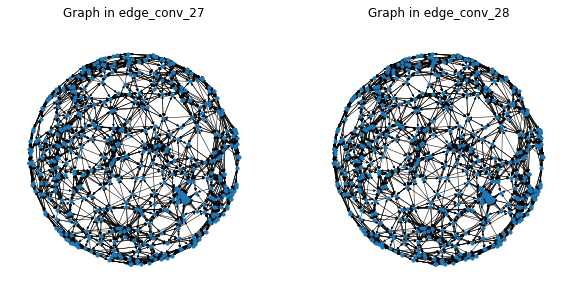

In [92]:
import tensorflow.keras.backend as K
from sklearn.neighbors import kneighbors_graph
import networkx as nx

edge_layers = [l for l in model.layers if "edge_conv" in l.name]
coord_mask = [np.sum(np.linalg.norm(inp_d[test_id], axis=-1)) == 500 for inp_d in train_input_data]
assert True in coord_mask, "For plotting the spherical graph at least one input has to have 3 dimensions XYZ"
fig, axes = plt.subplots(ncols=len(edge_layers), figsize=(5 * len(edge_layers), 5))

for i, e_layer in enumerate(edge_layers):
    points_in, feats_in = model.inputs
    coordinates = e_layer.get_input_at(0)
    functor = K.function(model.inputs, coordinates)
    sample_input = [inp[np.newaxis, test_id] for inp in train_input_data]

    if type(e_layer.input) == list:
        layer_points, layer_features = functor(sample_input)
    else:
        layer_points = functor(sample_input)

    layer_points = np.squeeze(layer_points)
    adj = kneighbors_graph(layer_points, e_layer.next_neighbors)
    g = nx.DiGraph(adj)

    for c, s in zip(coord_mask, sample_input):
        if c == True:
            pos = s
            break

    axes[i].set_title("Graph in %s" % e_layer.name)
    nx.draw(g, cmap=plt.get_cmap('viridis'), pos=pos.squeeze()[:, :-1],
            node_size=10, width=0.5, arrowsize=5, ax=axes[i])
    axes[i].axis('equal')